# ECT on Matisse's "The Parakeet and the Mermaid" 

Here, we are going to give an example of using the ECT to classify the cutout shapes from Henri Matisse's 1952 ["The Parakeet and the Mermaid"](https://www.moma.org/audio/playlist/6/312). 

![matisse.jpg](matisse.jpg)


In [1]:
#-----------------
# Standard imports 
#-----------------
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
from sklearn.decomposition import PCA # for PCA for normalization
from scipy.spatial import distance_matrix

from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from sklearn.manifold import MDS # for MDS
import pandas as pd # for loading in colors csv

#---------------------------
# The ECT packages we'll use
#---------------------------
from ect import ECT, EmbeddedGraph # for calculating ECTs


We've taken care of the preprocessing in advance by extracting out the shapes from the image.  You can download these outlines here: [outlines.zip](outlines.zip).

<img src="matisse_numbered.jpg" alt="Matisse Numbered" style="width:50%;">

In [2]:
data_dir = "doc_source/notebooks/Matisse/outlines/" # set data directory
file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and f[-4:] == '.txt'] # create a list of file names
file_names.sort() # sort the list of file names
print(f"There are {len(file_names)} files in the directory") # print number of files

There are 150 files in the directory


Here we have an example of one of these leaves loaded in as an `EmbeddedGraph` class.

<Axes: >

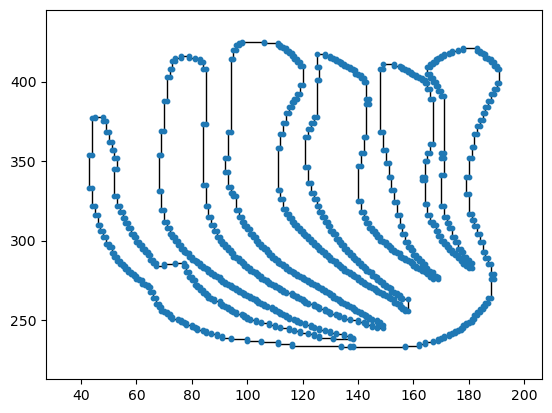

In [3]:
i = 3
shape = np.loadtxt(data_dir + file_names[i])
# shape = normalize(shape)
G = EmbeddedGraph()
G.add_cycle(shape)
G.plot(with_labels = False, node_size = 10)

We're going to align the leaf using the PCA coordinates, min-max center, and scale it to fit in a ball of radius 1 for ease of comparisons. 

<Axes: >

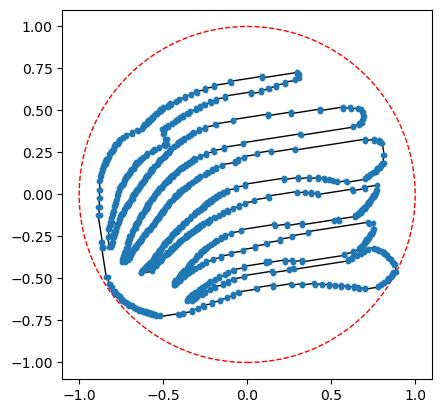

In [4]:
G.set_PCA_coordinates( center_type='min_max', scale_radius=1)
G.plot(with_labels = False, node_size = 10, bounding_circle=True)

And then we can compute the ECT of this leaf. 

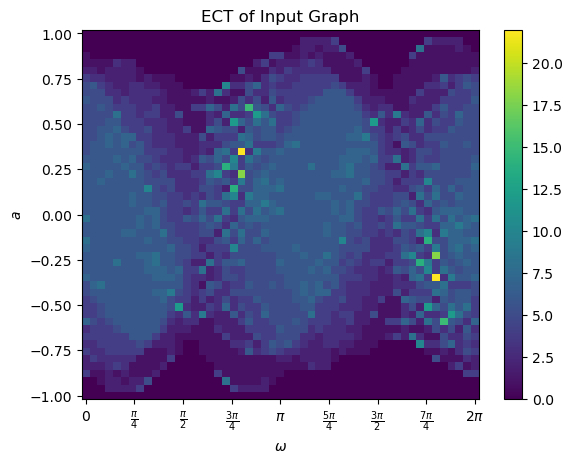

In [5]:
num_dirs=50 # set number of directional axes
num_thresh=50 # set number of thresholds each axis

myect = ECT(num_dirs = num_dirs, num_thresh=num_thresh) # intiate ECT
myect.set_bounding_radius(1) # set bounding radius
myect.calculateECT(G) # calculate ECT on embedded graph

myect.plotECT() # plot ECT


Let's just make a data loader with all of this for ease in a bit. 

In [6]:
def matisse_ect(filename, num_dirs, num_thresh):
    shape = np.loadtxt(data_dir + filename)
    G = EmbeddedGraph()
    G.add_cycle(shape)
    G.set_PCA_coordinates( center_type='min_max', scale_radius=1)
    myect = ECT(num_dirs = num_dirs, num_thresh=num_thresh) 
    myect.set_bounding_radius(1) 
    M = myect.calculateECT(G) 
    return M

And now we can load in all the outlines, compute their ECT and store it in a 3D array. 

In [7]:
num_dirs=50 # set number of directional axes
num_thresh=50 # set number of thresholds each axis

ect_arr = np.zeros((len(file_names),num_dirs,num_thresh))
for i in range(len(file_names)): # for each leaf
    ect_arr[i,:,:] = matisse_ect(file_names[i], num_dirs, num_thresh)

Here, we are just going to compute the distance between two ECTs using $L_2$ distance. 

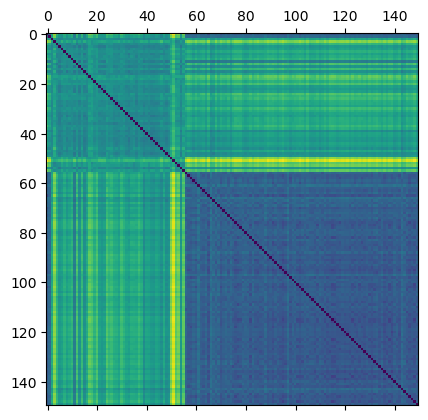

In [8]:
flattened_ect = ect_arr.reshape(len(file_names), num_dirs*num_thresh)
D = distance_matrix(flattened_ect, flattened_ect)
plt.matshow(D)

For visualization purposes, we can project this data into 2D using Multi Dimensional Scaling (MDS). Here we plot each figure at the MDS coordinates. 

In [9]:
n_components = 2 # select number of components
mds = MDS(n_components=n_components, # initialize MDS
          dissimilarity="precomputed", # we have precomputed the distance matrix
          normalized_stress='auto',
          random_state=5 # select random state for reproducibility
         )
MDS_scores = mds.fit_transform(D) # get MDS scores

Text(0.5, 1.0, "MDS of Matisse's Leaves via ECT distances")

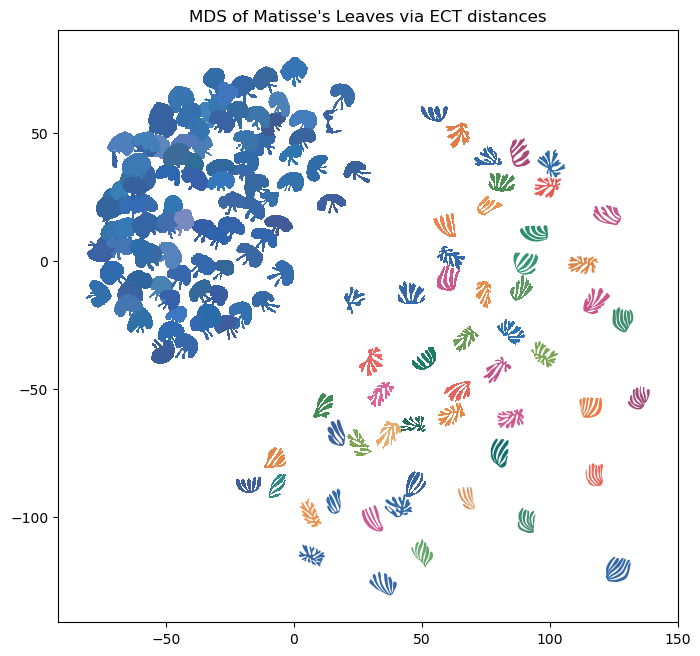

In [10]:
# read in color hexcodes
col_df = pd.read_csv("doc_source/notebooks/Matisse/colors.csv", header=None) 

scale_val = 6 # set scale value
plt.figure(figsize=(8,8)) # set figure dimensions

for i in range(len(file_names)): # for each leaf
    shape = np.loadtxt(data_dir+file_names[i]) # get the current shape
    shape = shape - np.mean(shape, axis=0) # zero center shape
    shape = scale_val * shape / max(np.linalg.norm(shape, axis = 1)) # scale to radius 1 then mult by scale_val

    trans_sh = (shape + MDS_scores[i]) # translate shape to MDS position

    plt.fill(trans_sh[:,0], trans_sh[:,1], c=col_df[0][i], lw=0) # plot shape
    plt.gca().set_aspect("equal")

plt.title("MDS of Matisse's Leaves via ECT distances")

## Acknowledgements

This notebook was written by [Liz Munch](https://elizabethmunch.com/) based on [original code](https://github.com/DanChitwood/matisse_test) from [Dan Chitwood](https://www.canr.msu.edu/people/dr_dan_chitwood). 